In [3]:
# set the kernel of this cell as Python3
print("hello world!")

hello world!


In [4]:
!pip install seaborn
!pip install statsmodels
!pip install scikit-learn

In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns # pretty plotting, similar to ggplot2
import matplotlib.pyplot as plt # base plots

import statsmodels.api as sm # similar to glm() in R
import statsmodels.formula.api as smf

from scipy.stats import norm
from scipy.stats import t
from sklearn.preprocessing import scale

In [6]:
toy_data = pd.read_table("toy_data.tsv", low_memory=False)
toy_data.head()

,ID,f.131057.0.0,f.131369.0.0,f.131056.0.0,f.131368.0.0,f.31.0.0,f.33.0.0
0,801313,51.0,50.0,1993-02-09,2008-07-22,0,1958-10-12
1,959469,NaN,NaN,NaN,NaN,1,1948-01-22
2,954457,40.0,NaN,2003-08-16,NaN,0,1973-02-09
3,711984,NaN,NaN,NaN,NaN,1,1951-09-08
4,881953,NaN,50.0,NaN,2018-06-04,1,1951-01-21


In [8]:
# Count males and females
num_males = toy_data[toy_data['f.31.0.0'] == 1].shape[0]
num_females = toy_data[toy_data['f.31.0.0'] == 0].shape[0]

print(f"Number of Males: {num_males}")
print(f"Number of Females: {num_females}")

# Calculate average age of females
# First, convert birthdate column to datetime
toy_data['birthdate'] = pd.to_datetime(toy_data['f.33.0.0'], errors='coerce')

# Filter females and calculate age
females = toy_data[toy_data['f.31.0.0'] == 0]
now = pd.to_datetime('2024-01-01')
females['age'] = (now - females['birthdate']).dt.days / 365.25

# Calculate average age of females
average_age_females = females['age'].mean()
print(f"Average Age of Females: {average_age_females:.2f} years")

Number of Males: 49815
Number of Females: 50185
Average Age of Females: 63.92 years


/var/folders/p5/41bczx01619_p0_4j5n02rvw0000gn/T/ipykernel_54596/837474771.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  females['age'] = (now - females['birthdate']).dt.days / 365.25


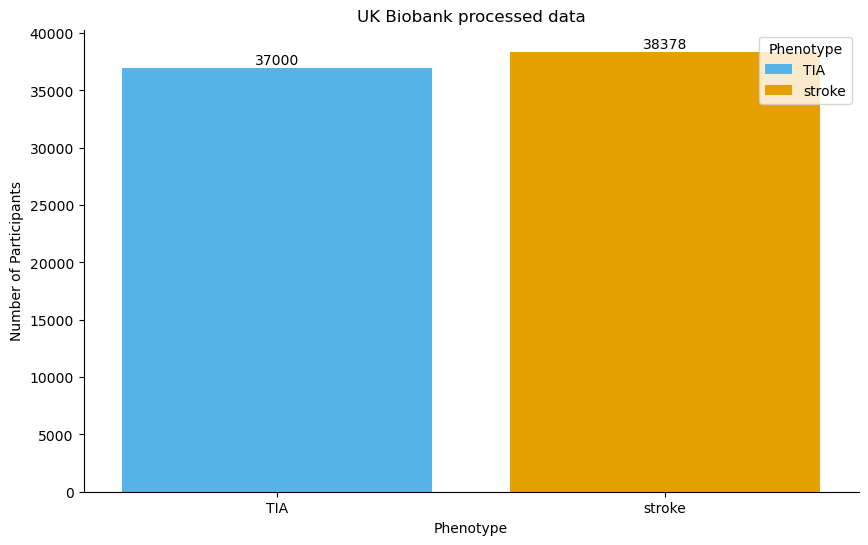

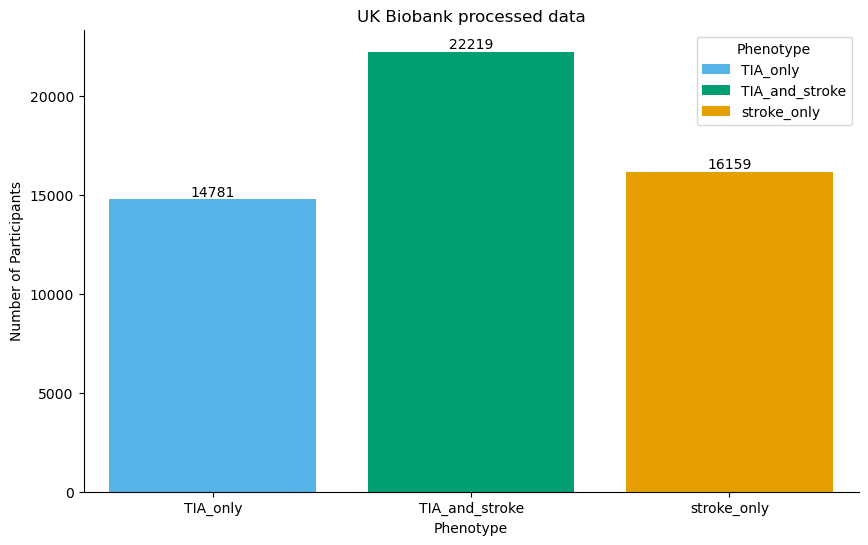

In [16]:
toy_data = toy_data.rename(columns={
    'f.131057.0.0': 'TIA_first_occurrence',
    'f.131369.0.0': 'stroke_first_occurrence'
})

# Checking what variable TIA_first_occurrence contains
#   the variable includes codes for the diagnosis source and is missing (NA) for sampled without diagosis
#   (40=Hospital admissions data only, 50=Self-report only, 51=Self-report and other source(s))
toy_data['TIA_first_occurrence'].value_counts(dropna=False)

# Extract the number of participants with a non-missing value for the first occurrence
tmp = {
    'TIA': toy_data['TIA_first_occurrence'].notna().sum(),
    'stroke': toy_data['stroke_first_occurrence'].notna().sum()
}

# Convert the dictionary to a DataFrame
tmp = pd.DataFrame(list(tmp.items()), columns=['phenotype', 'number_of_participants'])

# tmp = pd.DataFrame(list(tmp.items()), columns=['phenotype', 'number_of_participants']).set_index('phenotype')

# Define the colors for the bars
colors = ["#56B4E9", "#E69F00"]

# Plot the totals using seaborn
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=tmp, x='phenotype', y='number_of_participants', hue='phenotype', legend=True, dodge=False, palette=colors, saturation=1)
sns.despine()

for x in range(0,2):
    ax.bar_label(ax.containers[x])

plt.title('UK Biobank processed data')
plt.xlabel('Phenotype')
plt.ylabel('Number of Participants')
plt.legend(title='Phenotype')

plt.show()

# Extract the three combinations: only TIA, both TIA & stroke, and only stroke
tmp = {
    'TIA_only': ((toy_data['TIA_first_occurrence'].notna()) & (toy_data['stroke_first_occurrence'].isna())).sum(),
    'stroke_only': ((toy_data['stroke_first_occurrence'].notna()) & (toy_data['TIA_first_occurrence'].isna())).sum(),
    'TIA_and_stroke': (toy_data['TIA_first_occurrence'].notna() & toy_data['stroke_first_occurrence'].notna()).sum()
}

# Convert the dictionary to a DataFrame
tmp = pd.DataFrame(list(tmp.items()), columns=['phenotype', 'number_of_participants'])

# Set the order for plotting
tmp['phenotype'] = pd.Categorical(tmp['phenotype'], categories=['TIA_only', 'TIA_and_stroke', 'stroke_only'], ordered=True)

# Define the colors for the bars
colors= ["#56B4E9","#009E73","#E69F00"]

# Plot the totals using seaborn
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=tmp, x='phenotype', y='number_of_participants', hue='phenotype', legend=True, dodge=False, palette=colors, saturation=1)
sns.despine() 

for x in range(0,3):
    ax.bar_label(ax.containers[x])

plt.title('UK Biobank processed data')
plt.xlabel('Phenotype')
plt.ylabel('Number of Participants')
# plt.legend(title='Phenotype')
ax.legend(title='Phenotype')
plt.show()

Columns renamed!


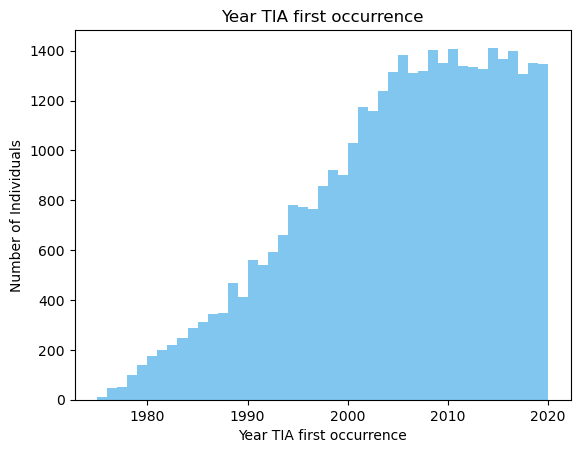

In [17]:
if 'f.131056.0.0' in toy_data.columns and 'f.131368.0.0' in toy_data.columns:  # Check if the columns exist to prevent errors on rerun
    toy_data.rename(columns={
        'f.131056.0.0': 'TIA_date_first_occurrence',
        'f.131368.0.0': 'stroke_date_first_occurrence'
    }, inplace=True)
    print("Columns renamed!")
else:
    print("Columns have already been renamed!")

# Extract years from dates
toy_data['TIA_year_first_occurrence'] = pd.to_datetime(toy_data['TIA_date_first_occurrence']).dt.year
toy_data['stroke_year_first_occurrence'] = pd.to_datetime(toy_data['stroke_date_first_occurrence']).dt.year

# Plot a histogram of TIA year of first occurrence from individuals for whom it's not missing
sns.histplot(toy_data['TIA_year_first_occurrence'].dropna(), kde=False, bins=range(int(toy_data['TIA_year_first_occurrence'].min()), int(toy_data['TIA_year_first_occurrence'].max()) + 2),
            color='#56B4E9', linewidth=0)
plt.title('Year TIA first occurrence')
plt.xlabel('Year TIA first occurrence')
plt.ylabel('Number of Individuals')
plt.show()

/var/folders/p5/41bczx01619_p0_4j5n02rvw0000gn/T/ipykernel_54596/128162741.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['TIA', 'stroke'], y=[num_TIA, num_stroke], palette=['#56B4E9', '#E69F00'])


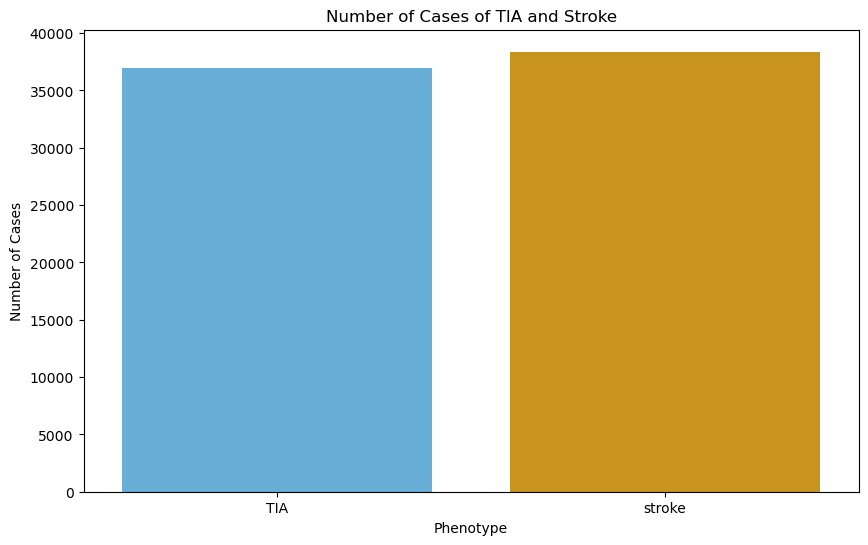

/var/folders/p5/41bczx01619_p0_4j5n02rvw0000gn/T/ipykernel_54596/128162741.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['TIA only', 'TIA and stroke', 'Stroke only'], y=[TIA_only, TIA_and_stroke, stroke_only], palette=['#56B4E9', '#009E73', '#E69F00'])


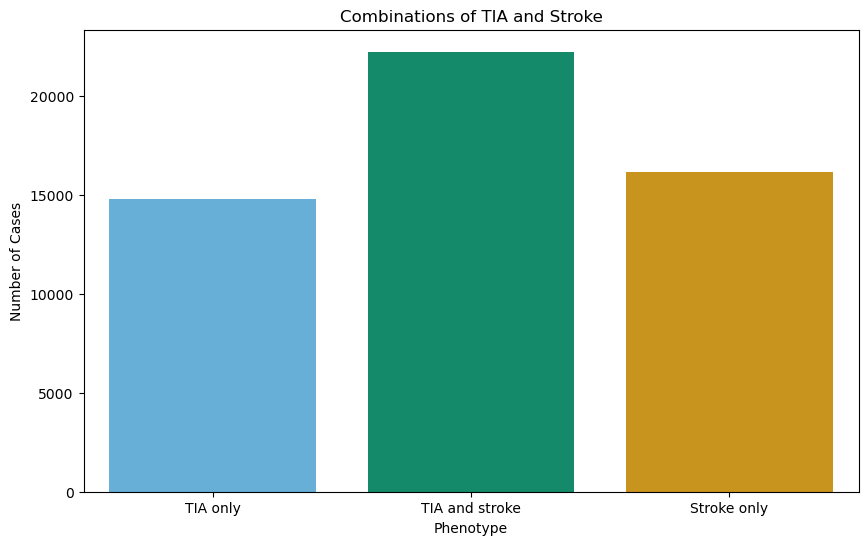

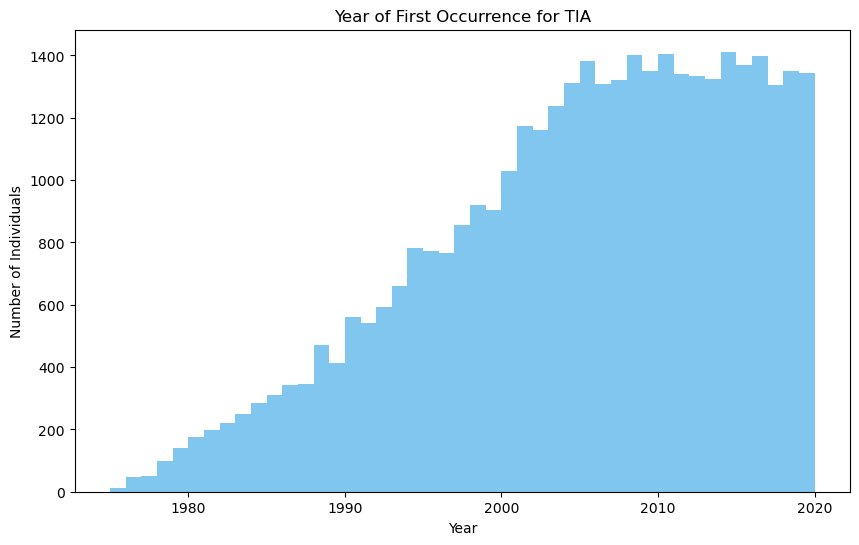

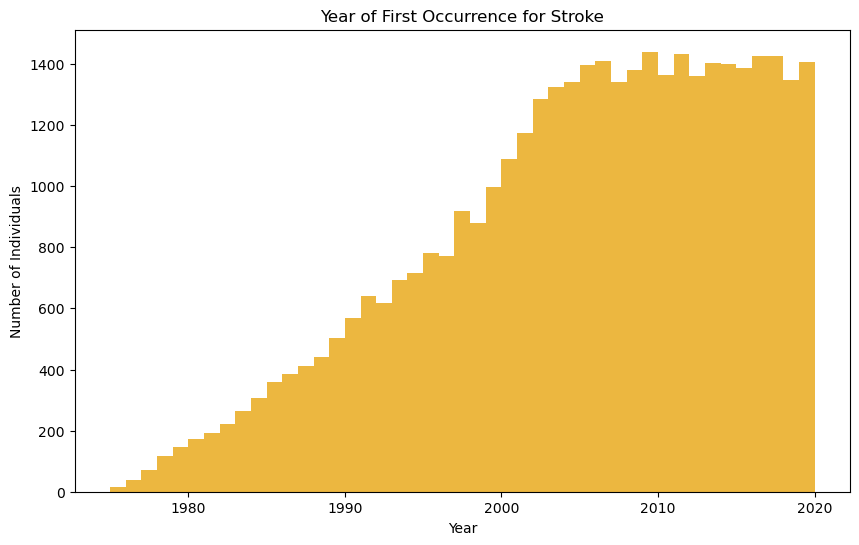

In [18]:
#Q2
# Rename the columns related to TIA and stroke for better readability
toy_data = toy_data.rename(columns={
    'f.131057.0.0': 'TIA_first_occurrence',
    'f.131369.0.0': 'stroke_first_occurrence'
})

# Count the number of cases of TIA and stroke
num_TIA = toy_data['TIA_first_occurrence'].notna().sum()
num_stroke = toy_data['stroke_first_occurrence'].notna().sum()

# Plot the counts of TIA and stroke
plt.figure(figsize=(10, 6))
sns.barplot(x=['TIA', 'stroke'], y=[num_TIA, num_stroke], palette=['#56B4E9', '#E69F00'])
plt.title('Number of Cases of TIA and Stroke')
plt.xlabel('Phenotype')
plt.ylabel('Number of Cases')
plt.show()

# Count the combinations of TIA and stroke
TIA_only = ((toy_data['TIA_first_occurrence'].notna()) & (toy_data['stroke_first_occurrence'].isna())).sum()
stroke_only = ((toy_data['stroke_first_occurrence'].notna()) & (toy_data['TIA_first_occurrence'].isna())).sum()
TIA_and_stroke = (toy_data['TIA_first_occurrence'].notna() & toy_data['stroke_first_occurrence'].notna()).sum()

# Plot the combinations of TIA and stroke
plt.figure(figsize=(10, 6))
sns.barplot(x=['TIA only', 'TIA and stroke', 'Stroke only'], y=[TIA_only, TIA_and_stroke, stroke_only], palette=['#56B4E9', '#009E73', '#E69F00'])
plt.title('Combinations of TIA and Stroke')
plt.xlabel('Phenotype')
plt.ylabel('Number of Cases')
plt.show()

# Extract years from dates for TIA and stroke
toy_data['TIA_year_first_occurrence'] = pd.to_datetime(toy_data['TIA_date_first_occurrence']).dt.year
toy_data['stroke_year_first_occurrence'] = pd.to_datetime(toy_data['stroke_date_first_occurrence']).dt.year

# Plot histograms of the year of first occurrence for TIA and stroke
plt.figure(figsize=(10, 6))
sns.histplot(toy_data['TIA_year_first_occurrence'].dropna(), kde=False, bins=range(int(toy_data['TIA_year_first_occurrence'].min()), int(toy_data['TIA_year_first_occurrence'].max()) + 2), color='#56B4E9', linewidth=0)
plt.title('Year of First Occurrence for TIA')
plt.xlabel('Year')
plt.ylabel('Number of Individuals')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(toy_data['stroke_year_first_occurrence'].dropna(), kde=False, bins=range(int(toy_data['stroke_year_first_occurrence'].min()), int(toy_data['stroke_year_first_occurrence'].max()) + 2), color='#E69F00', linewidth=0)
plt.title('Year of First Occurrence for Stroke')
plt.xlabel('Year')
plt.ylabel('Number of Individuals')
plt.show()

/var/folders/p5/41bczx01619_p0_4j5n02rvw0000gn/T/ipykernel_54596/3207446024.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Before 2000', 'After 2000'], y=[num_TIA_before_2000, num_TIA_after_2000], palette=['#56B4E9', '#E69F00'])


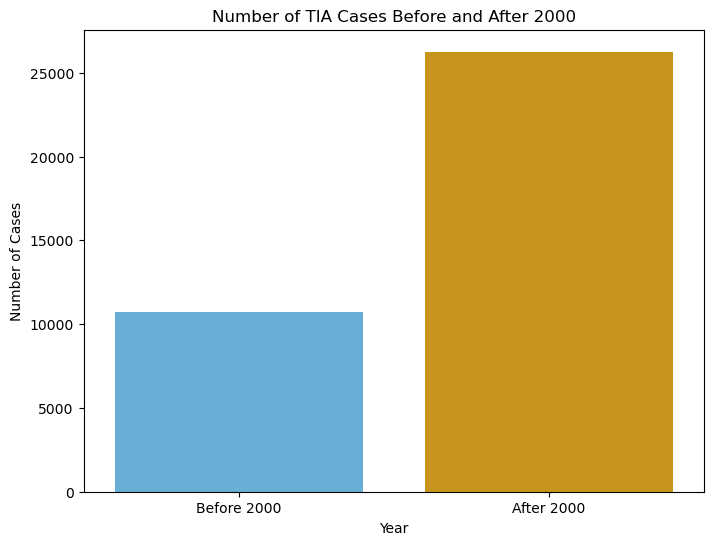

In [19]:
# Q3
# Convert TIA year of first occurrence to datetime objects
toy_data['TIA_year_first_occurrence'] = pd.to_datetime(toy_data['TIA_year_first_occurrence'], format='%Y')

# Count the number of TIA cases before and after 2000
num_TIA_before_2000 = (toy_data['TIA_year_first_occurrence'] < '2000-01-01').sum()
num_TIA_after_2000 = (toy_data['TIA_year_first_occurrence'] >= '2000-01-01').sum()

# Create a bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x=['Before 2000', 'After 2000'], y=[num_TIA_before_2000, num_TIA_after_2000], palette=['#56B4E9', '#E69F00'])
plt.title('Number of TIA Cases Before and After 2000')
plt.xlabel('Year')
plt.ylabel('Number of Cases')
plt.show()

In [20]:
toy_data.to_csv('toy_data_renamed.tsv', sep='\t', index=False)

In [22]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns # pretty plotting, similar to ggplot2
import matplotlib.pyplot as plt # base plots

import statsmodels.api as sm # similar to glm() in R
import statsmodels.formula.api as smf

from scipy.stats import norm
from scipy.stats import t
from sklearn.preprocessing import scale


PRS = pd.read_table("toy_data_PRS.tsv", low_memory=False)
PRS.head()

,ID,TIA_PRS,stroke_PRS
0,100001,0.615897,0.663288
1,100015,0.487190,0.455392
2,100026,0.665074,0.313975
3,100029,0.733666,0.545491
4,100041,0.515659,0.431386


In [23]:
toy_data = pd.read_table("toy_data_renamed.tsv", low_memory=False)

In [24]:
# Q4
%get toy_data --from Python3

UsageError: Line magic function `%get` not found.


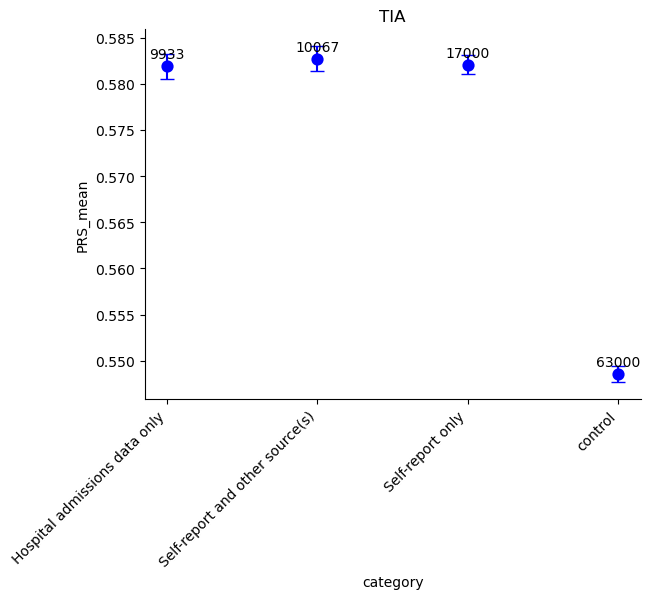

In [25]:
# Q5
df_PRS = pd.merge(PRS, toy_data, on='ID', how='left')
# define diagnosis category
df_PRS['TIA_first_occurrence_category'] = df_PRS['TIA_first_occurrence'].map({
    20: 'Death register only',
    21: 'Death register and other source(s)',
    30: 'Primary care only',
    31: 'Primary care and other source(s)',
    40: 'Hospital admissions data only',
    41: 'Hospital admissions data and other source(s)',
    50: 'Self-report only',
    51: 'Self-report and other source(s)'
}).fillna('control')

# TIA
grouped_TIA = df_PRS.groupby('TIA_first_occurrence_category')
df_PRS_means_TIA = grouped_TIA.agg(
    N=('TIA_PRS', 'size'),
    PRS_mean=('TIA_PRS', 'mean'),
    PRS_std=('TIA_PRS', 'std')
)
df_PRS_means_TIA['ci_low'] = df_PRS_means_TIA['PRS_mean'] - t.ppf(1 - 0.05 / 2, df_PRS_means_TIA['N'] - 1) * df_PRS_means_TIA['PRS_std'] / (df_PRS_means_TIA['N']**0.5)
df_PRS_means_TIA['ci_upper'] = df_PRS_means_TIA['PRS_mean'] + t.ppf(1 - 0.05 / 2, df_PRS_means_TIA['N'] - 1) * df_PRS_means_TIA['PRS_std'] / (df_PRS_means_TIA['N']**0.5)
df_PRS_means_TIA.reset_index(inplace=True)
df_PRS_means_TIA.rename(columns={'TIA_first_occurrence_category': 'category'}, inplace=True)

data = df_PRS_means_TIA
sns.pointplot(data=data, x='category', y='PRS_mean', color='blue', linestyle='none', errorbar=None)
plt.errorbar(data['category'], data['PRS_mean'], yerr=[data['PRS_mean'] - data['ci_low'], data['ci_upper'] - data['PRS_mean']], fmt='none', color='blue', capsize=5)


# Annotate with the number of participants
for i, row in data.iterrows():
    plt.text(row['category'], row['PRS_mean'] + 0.0005, str(row['N']), ha='center', va='bottom')

# Set the title for the subplot
plt.title('TIA')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45, ha='right')

# Turn off grid
plt.grid(False)

# Set background to blank and draw axis lines
plt.gca().set_facecolor('white')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

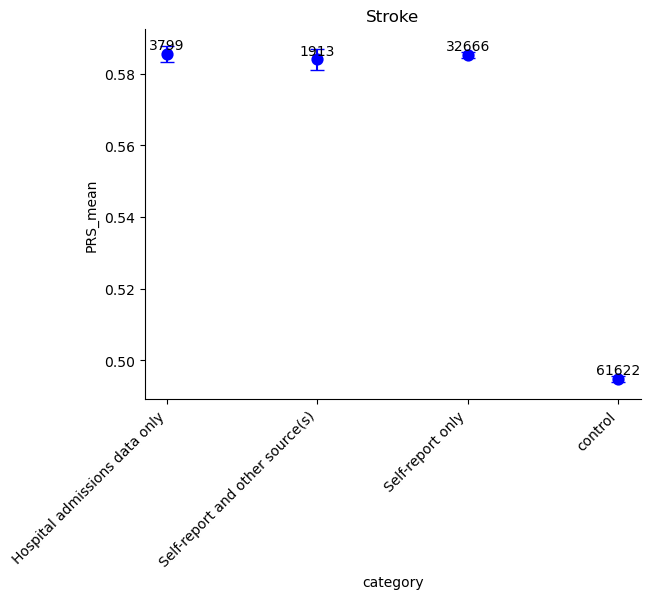

In [28]:
# Define diagnosis category for stroke
df_PRS['stroke_first_occurrence_category'] = df_PRS['stroke_first_occurrence'].map({
    20: 'Death register only',
    21: 'Death register and other source(s)',
    30: 'Primary care only',
    31: 'Primary care and other source(s)',
    40: 'Hospital admissions data only',
    41: 'Hospital admissions data and other source(s)',
    50: 'Self-report only',
    51: 'Self-report and other source(s)'
}).fillna('control')

# Stroke
grouped_stroke = df_PRS.groupby('stroke_first_occurrence_category')
df_PRS_means_stroke = grouped_stroke.agg(
    N=('stroke_PRS', 'size'),
    PRS_mean=('stroke_PRS', 'mean'),
    PRS_std=('stroke_PRS', 'std')
)
df_PRS_means_stroke['ci_low'] = df_PRS_means_stroke['PRS_mean'] - t.ppf(1 - 0.05 / 2, df_PRS_means_stroke['N'] - 1) * df_PRS_means_stroke['PRS_std'] / (df_PRS_means_stroke['N']**0.5)
df_PRS_means_stroke['ci_upper'] = df_PRS_means_stroke['PRS_mean'] + t.ppf(1 - 0.05 / 2, df_PRS_means_stroke['N'] - 1) * df_PRS_means_stroke['PRS_std'] / (df_PRS_means_stroke['N']**0.5)
df_PRS_means_stroke.reset_index(inplace=True)
df_PRS_means_stroke.rename(columns={'stroke_first_occurrence_category': 'category'}, inplace=True)

# Plotting
data_stroke = df_PRS_means_stroke
sns.pointplot(data=data_stroke, x='category', y='PRS_mean', color='blue', linestyle='none', errorbar=None)
plt.errorbar(data_stroke['category'], data_stroke['PRS_mean'], yerr=[data_stroke['PRS_mean'] - data_stroke['ci_low'], data_stroke['ci_upper'] - data_stroke['PRS_mean']], fmt='none', color='blue', capsize=5)

# Annotate with the number of participants
for i, row in data_stroke.iterrows():
    plt.text(row['category'], row['PRS_mean'] + 0.0005, str(row['N']), ha='center', va='bottom')

# Set the title for the subplot
plt.title('Stroke')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45, ha='right')

# Turn off grid
plt.grid(False)

# Set background to blank and draw axis lines
plt.gca().set_facecolor('white')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()


In [27]:
df_PRS

,ID,TIA_PRS,stroke_PRS,TIA_first_occurrence,stroke_first_occurrence,TIA_date_first_occurrence,stroke_date_first_occurrence,f.31.0.0,f.33.0.0,birthdate,TIA_year_first_occurrence,stroke_year_first_occurrence,TIA_first_occurrence_category
0,100001,0.615897,0.663288,40.0,NaN,2008-02-11,NaN,1,1974-05-02,1974-05-02,2008-01-01,NaN,Hospital admissions data only
1,100015,0.487190,0.455392,NaN,NaN,NaN,NaN,1,1948-08-24,1948-08-24,NaN,NaN,control
2,100026,0.665074,0.313975,51.0,NaN,2003-08-17,NaN,1,1946-10-26,1946-10-26,2003-01-01,NaN,Self-report and other source(s)
3,100029,0.733666,0.545491,NaN,NaN,NaN,NaN,1,1959-04-08,1959-04-08,NaN,NaN,control
4,100041,0.515659,0.431386,NaN,NaN,NaN,NaN,1,1960-06-17,1960-06-17,NaN,NaN,control
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,999934,0.485374,0.358468,NaN,NaN,NaN,NaN,1,1971-11-12,1971-11-12,NaN,NaN,control
99996,999952,0.698541,0.423063,NaN,NaN,NaN,NaN,1,1957-06-13,1957-06-13,NaN,NaN,control
99997,999956,0.633221,0.249921,NaN,NaN,NaN,NaN,1,1946-09-29,1946-09-29,NaN,NaN,control
99998,999958,0.601377,0.583237,NaN,NaN,NaN,NaN,0,1947-04-02,1947-04-02,NaN,NaN,control
